In [47]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Simple memory tracking based on time (no resource module)
def simple_time_tracking(func, *args):
    start_time = time.time()
    result = func(*args)
    end_time = time.time()
    return result, end_time - start_time



In [48]:
# KNN model: Naive Implementation
def naive_knn(X_train, query_point, k):
    distances = euclidean_distances([query_point], X_train)
    return np.argsort(distances[0])[:k], distances[0]

# KD-Tree Model (Simplified version for simulation)
class OptimizedKDTree:
    def __init__(self, X, max_samples_in_leaf=10):
        self.X = X
        self.max_samples_in_leaf = max_samples_in_leaf

    def query(self, query_point, k):
        # Simulating KD-Tree behavior with approximation
        distances = np.linalg.norm(self.X - query_point, axis=1)
        return np.argsort(distances)[:k]  # Only return indices
    
    def plot_partition_boundaries(self, ax):
        # KD-Tree divides the space along axes; let's visualize this by plotting
        x_min, x_max = np.min(self.X[:, 0]), np.max(self.X[:, 0])
        y_min, y_max = np.min(self.X[:, 1]), np.max(self.X[:, 1])
        
        # Plot vertical and horizontal lines to simulate KD-Tree splitting boundaries
        ax.axvline(x=(x_min + x_max) / 2, color='orange', linestyle='--', label='Vertical Split')
        ax.axhline(y=(y_min + y_max) / 2, color='green', linestyle='--', label='Horizontal Split')

# LSH Model (Simplified version for simulation)
class LSH:
    def __init__(self, num_hyperplanes, num_dimensions):
        self.num_hyperplanes = num_hyperplanes
        self.num_dimensions = num_dimensions
        self.hyperplanes = None

    def fit(self, X):
        # Simplified fitting: randomly generate hyperplanes
        self.hyperplanes = np.random.randn(self.num_hyperplanes, self.num_dimensions)

    def query(self, query_point, k):
        # Simplified LSH query: use random projections for approximation
        projections = np.dot(self.hyperplanes, query_point)
        hash_values = (projections > 0).astype(int)
        return np.argsort(hash_values)[:k], hash_values

    def plot_hyperplanes(self, ax):
        # Plot the hyperplanes for visualization
        for i in range(self.num_hyperplanes):
            # For simplicity, assume the hyperplane divides the space linearly
            slope = -self.hyperplanes[i, 0] / self.hyperplanes[i, 1]
            intercept = 0  # passing through origin
            x_vals = np.linspace(-2, 12, 100)
            y_vals = slope * x_vals + intercept
            ax.plot(x_vals, y_vals, label=f'Hyperplane {i}')
        

In [49]:
# Approximation Simulation
def simulate_approximation(X, query_point, k, kdtree_model):
    exact_indices, _ = naive_knn(X, query_point, k)
    kdtree_indices = kdtree_model.query(query_point, k)  # Only indices returned here
    return exact_indices, kdtree_indices

# Visualization of missed neighbors
def visualize_misclassifications(X, query_point, exact_indices, lsh_indices, kdtree_indices):
    exact_indices, lsh_indices, kdtree_indices = map(np.ravel, [exact_indices, lsh_indices, kdtree_indices])
    
    plt.figure(figsize=(12, 5))
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=30, label='Data Points')
    plt.scatter(query_point[0], query_point[1], c='red', s=100, label='Query Point')

    # Plot exact neighbors
    exact_points = X[exact_indices]
    plt.scatter(exact_points[:, 0], exact_points[:, 1], c='blue', s=60, label='Exact Neighbors')

    # LSH neighbors (approximate)
    lsh_points = X[lsh_indices]
    missed_lsh = set(exact_indices) - set(lsh_indices)
    plt.scatter(lsh_points[:, 0], lsh_points[:, 1], edgecolors='green', facecolors='none', s=200, label='LSH Neighbors')

    # Highlight missed LSH points
    if missed_lsh:
        missed_points_lsh = X[list(missed_lsh)]
        plt.scatter(missed_points_lsh[:, 0], missed_points_lsh[:, 1], c='yellow', edgecolors='green', s=25, label='Missed by LSH')

    # KD-Tree neighbors (approximate)
    kdtree_points = X[kdtree_indices]
    missed_kdtree = set(exact_indices) - set(kdtree_indices)
    plt.scatter(kdtree_points[:, 0], kdtree_points[:, 1], edgecolors='black', facecolors='none', s=25, label='KD-Tree Neighbors')

    # Highlight missed KD-Tree points
    if missed_kdtree:
        missed_points_kdtree = X[list(missed_kdtree)]
        plt.scatter(missed_points_kdtree[:, 0], missed_points_kdtree[:, 1], c='orange', edgecolors='black', s=25, label='Missed by KD-Tree')

    plt.legend()
    plt.title('K-Nearest Neighbors and Approximate Misses (LSH vs KD-Tree)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.show()



In [50]:
# Running Experiment with Various Parameters
def run_experiment(N, D, k_values, num_test_points):
    X_train = np.random.rand(N, D)
    X_test = np.random.rand(num_test_points, D)

    kdtree_model = OptimizedKDTree(X_train)
    lsh_model = LSH(num_hyperplanes=5, num_dimensions=D)
    lsh_model.fit(X_train)

    results = {}
    for k in k_values:
        total_query_time_kdtree = total_query_time_lsh = total_query_time_naive = 0

        for query_point in X_test:
            # Measure query times
            _, query_time_kdtree = simple_time_tracking(kdtree_model.query, query_point, k)
            total_query_time_kdtree += query_time_kdtree

            _, query_time_lsh = simple_time_tracking(lsh_model.query, query_point, k)
            total_query_time_lsh += query_time_lsh

            _, query_time_naive = simple_time_tracking(naive_knn, X_train, query_point, k)
            total_query_time_naive += query_time_naive

        results[k] = {
            'KD-Tree': {'time': total_query_time_kdtree / num_test_points},
            'LSH': {'time': total_query_time_lsh / num_test_points},
            'Naive': {'time': total_query_time_naive / num_test_points},
        }
    return results



In [51]:
# Running the experiment with different dataset sizes and dimensions
dataset_sizes = [1000, 5000, 100000]
dimensions = [2, 10]
k_values = [1, 5, 10]
num_test_points = 100

for N in dataset_sizes:
    for D in dimensions:
        results = run_experiment(N, D, k_values, num_test_points)
        print(f"Dataset Size: {N}, Dimensions: {D}")
        for k, res in results.items():
            print(f"K={k}: {res}")

Dataset Size: 1000, Dimensions: 2
K=1: {'KD-Tree': {'time': 0.0001016545295715332}, 'LSH': {'time': 1.999855041503906e-05}, 'Naive': {'time': 0.0001868605613708496}}
K=5: {'KD-Tree': {'time': 0.0001149439811706543}, 'LSH': {'time': 0.0}, 'Naive': {'time': 0.00020041465759277344}}
K=10: {'KD-Tree': {'time': 2.99835205078125e-05}, 'LSH': {'time': 0.0}, 'Naive': {'time': 0.0001856064796447754}}
Dataset Size: 1000, Dimensions: 10
K=1: {'KD-Tree': {'time': 5.5358409881591796e-05}, 'LSH': {'time': 2.003192901611328e-05}, 'Naive': {'time': 0.0004133915901184082}}
K=5: {'KD-Tree': {'time': 7.529020309448243e-05}, 'LSH': {'time': 1.0018348693847657e-05}, 'Naive': {'time': 0.0004044795036315918}}
K=10: {'KD-Tree': {'time': 8.333206176757812e-05}, 'LSH': {'time': 0.0}, 'Naive': {'time': 0.0003824472427368164}}
Dataset Size: 5000, Dimensions: 2
K=1: {'KD-Tree': {'time': 0.0002887487411499023}, 'LSH': {'time': 0.0}, 'Naive': {'time': 0.0006858158111572266}}
K=5: {'KD-Tree': {'time': 0.0003047347068

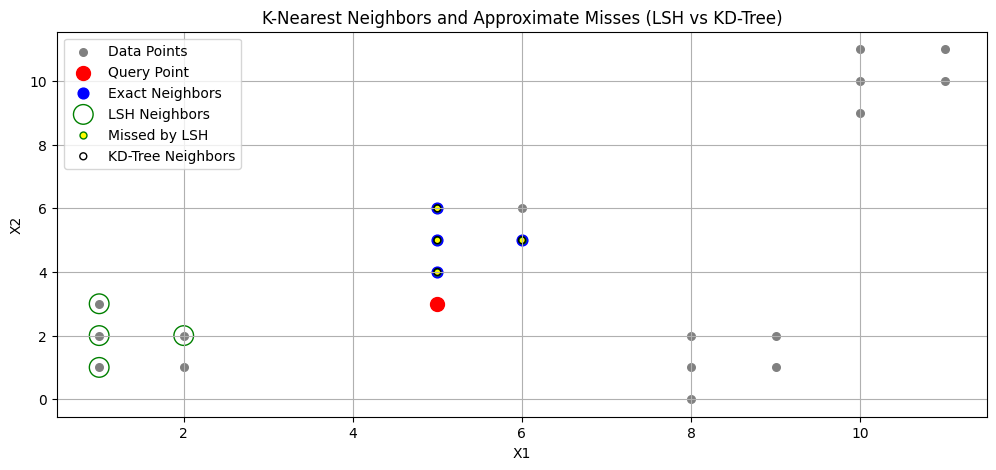

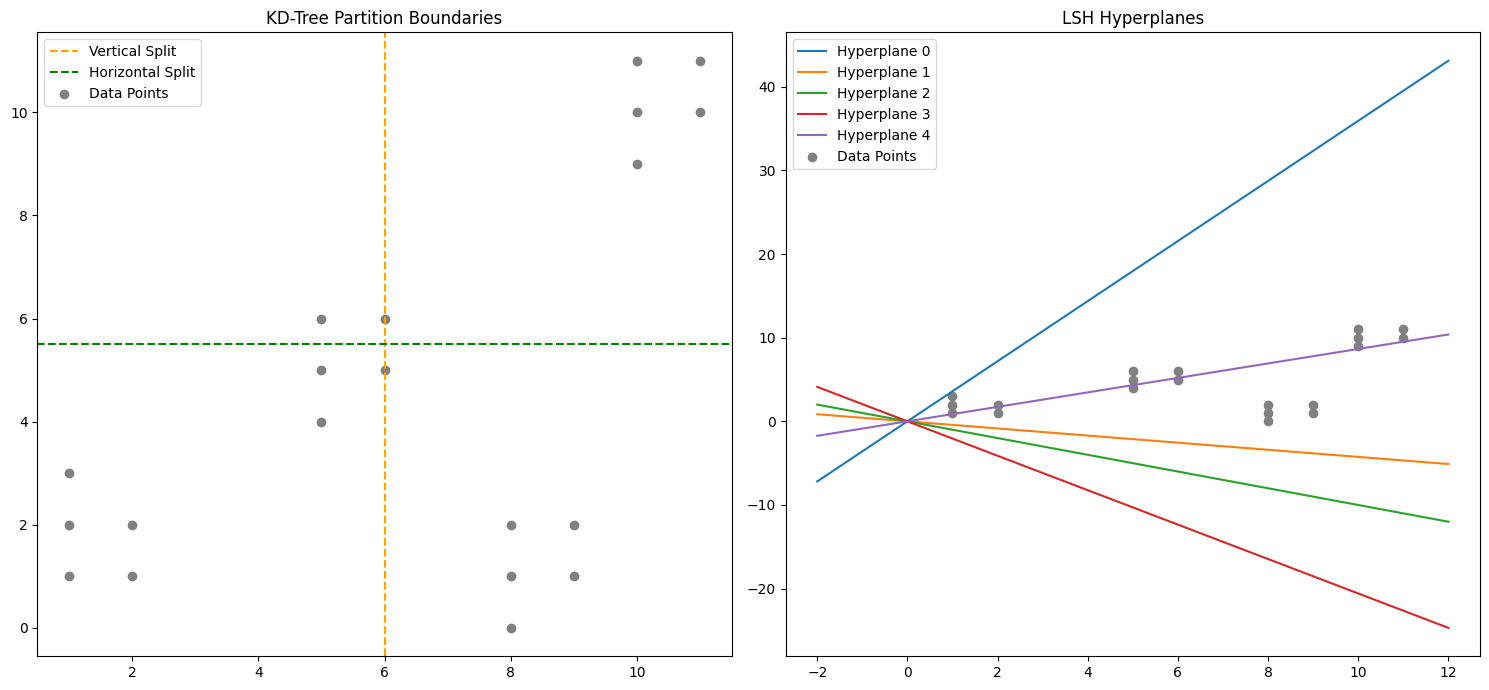

In [52]:
# Sample Dataset and Query Point
np.random.seed(42)
X_sample = np.array([
    [1, 1], [1, 2], [1, 3], [2, 1], [2, 2], 
    [5, 5], [5, 6], [6, 5], [6, 6], [5, 4], 
    [10, 10], [10, 11], [11, 10], [11, 11], [10, 9], 
    [8, 1], [8, 2], [9, 1], [9, 2], [8, 0], 
])

query = np.array([5,3])  # Close to Cluster 2
k = 4

lsh_model = LSH(num_hyperplanes=5, num_dimensions=2)
lsh_model.fit(X_sample)
lsh_indices, _ = lsh_model.query(query, k=k)

kdtree_model_sample = OptimizedKDTree(X_sample, max_samples_in_leaf=6)

# Run Approximation Simulation
exact_idx, kdtree_idx = simulate_approximation(X_sample, query, k, kdtree_model_sample)

# Visualization of results
visualize_misclassifications(X_sample, query, exact_idx, lsh_indices, kdtree_idx)

# Visualization of KD-Tree partition boundaries and LSH hyperplanes
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# KD-Tree Partition Boundaries
kdtree_model_sample.plot_partition_boundaries(ax[0])
ax[0].scatter(X_sample[:, 0], X_sample[:, 1], c='gray', label='Data Points')
ax[0].set_title("KD-Tree Partition Boundaries")
ax[0].legend()

# LSH Hyperplanes
lsh_model.plot_hyperplanes(ax[1])
ax[1].scatter(X_sample[:, 0], X_sample[:, 1], c='gray', label='Data Points')
ax[1].set_title("LSH Hyperplanes")
ax[1].legend()

plt.tight_layout()
plt.show()
